<a href="https://colab.research.google.com/github/joseph-tech-dev/machine-learning/blob/main/Tomato_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [29]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)



Found 4500 files belonging to 3 classes.


In [31]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

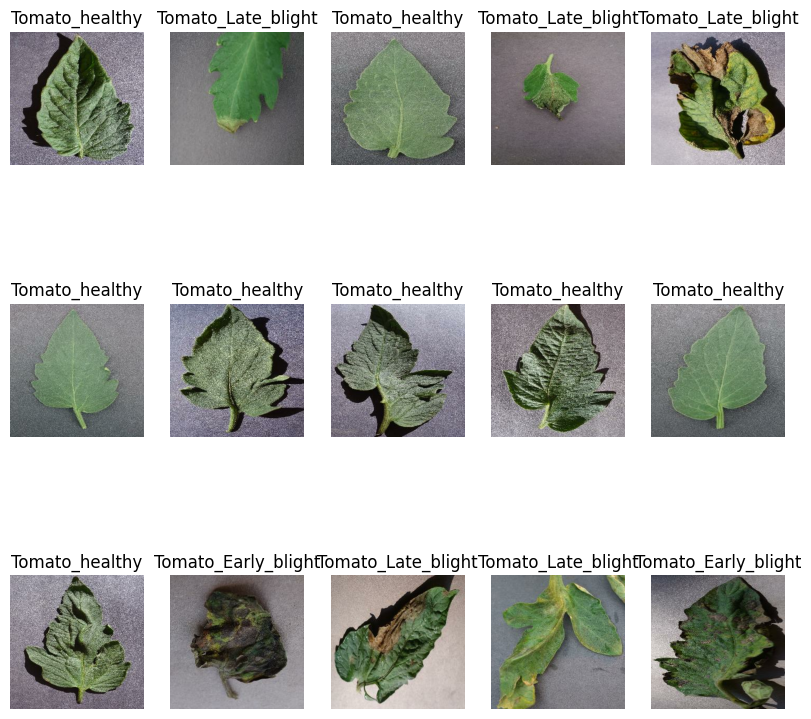

In [32]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [33]:
len(dataset)

141

In [34]:
# 80% ==> Training
# 20% ==> 10%  Validation, 10% Testing

In [35]:
# Define split percentages
#train_size = int(0.8 * len(dataset))
#val_size = int(0.1 * len(dataset))
#test_size = len(dataset) - train_size - val_size

# Split the dataset
#train_ds = dataset.take(train_size)
#val_ds = dataset.skip(train_size).take(val_size)
#test_ds = dataset.skip(train_size + val_size).take(test_size)

In [36]:
# function to split the Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  # Calculate the sizes of the partitions
  train_size = int(0.8 * len(ds))
  val_size = int(0.1 * len(ds))
  test_size = len(ds) - train_size - val_size

  # Splitting the dataset
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size + val_size).take(test_size)

  return train_ds, val_ds, test_ds



In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
print(f"Length of Training Dataset: {len(train_ds)}")
print(f"Length of Validation Dataset: {len(val_ds)}")
print(f"Length of Testing Dataset: {len(test_ds)}")


Length of Training Dataset: 112
Length of Validation Dataset: 14
Length of Testing Dataset: 15


In [39]:
# CACHING AND PRE-FETCHING ---> improve performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
# Rescaling and Resizing
# Incase during prediction the model recieves an image that is not 256 * 256
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255)
])


In [41]:
# DATA AUGMENTATION
# CREATE DIFFERENT TRANSFORMATION --> IMAGES OF DIFFERENT CONTRAST
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])


In [42]:
# Biulding the model
# Architecture: convolution > pooling
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.models.Sequential([
    # 1. Define the input explicitly for the model
    tf.keras.layers.Input(shape=input_shape),

    # 2. Preprocessing Layers (should maintain batch dimension)
    resize_and_rescale,
    data_augmentation,

    # 3. Convolutional Layers (Remove input_shape here, Input layer handles it)
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [45]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5506 - loss: 0.8790 - val_accuracy: 0.5982 - val_loss: 1.3878
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7841 - loss: 0.4980 - val_accuracy: 0.7768 - val_loss: 0.5142
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8701 - loss: 0.3197 - val_accuracy: 0.7812 - val_loss: 0.5091
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8705 - loss: 0.3086 - val_accuracy: 0.8013 - val_loss: 0.5191
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8594 - loss: 0.3532 - val_accuracy: 0.8750 - val_loss: 0.3179
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8942 - loss: 0.2496 - val_accuracy: 0.8728 - val_loss: 0.3487
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8981 - loss: 0.2692 - val_accuracy: 0.8929 - val_loss: 0.2315
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9085 - loss: 0.2217 - val_ac

In [46]:
history.history

{'accuracy': [0.671892523765564,
  0.8169093132019043,
  0.8656215071678162,
  0.8594624996185303,
  0.8748600482940674,
  0.8958566784858704,
  0.9034154415130615,
  0.8983762860298157,
  0.9168533086776733,
  0.9232922792434692,
  0.9305710792541504,
  0.9241321682929993,
  0.935330331325531,
  0.9426091909408569,
  0.9417693018913269,
  0.9529675245285034,
  0.9445688724517822,
  0.9596864581108093,
  0.9437289834022522,
  0.956606924533844,
  0.9594064950942993,
  0.9624860286712646,
  0.9501679539680481,
  0.9538074135780334,
  0.9619261026382446,
  0.956326961517334,
  0.956886887550354,
  0.9711645841598511,
  0.9711645841598511,
  0.9745240807533264,
  0.9664053916931152,
  0.9750840067863464,
  0.9742441177368164,
  0.9454087615013123,
  0.9678051471710205,
  0.9762037992477417,
  0.9694848656654358,
  0.9773236513137817,
  0.979563295841217,
  0.9773236513137817,
  0.9683650732040405,
  0.9798431992530823,
  0.978723406791687,
  0.9700447916984558,
  0.9764837622642517,
  0.9

In [47]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

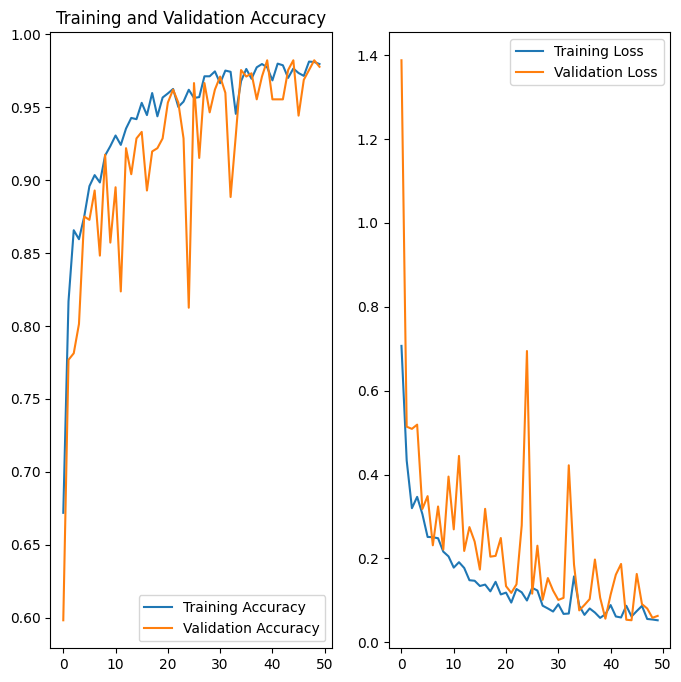

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')

In [72]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 3)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


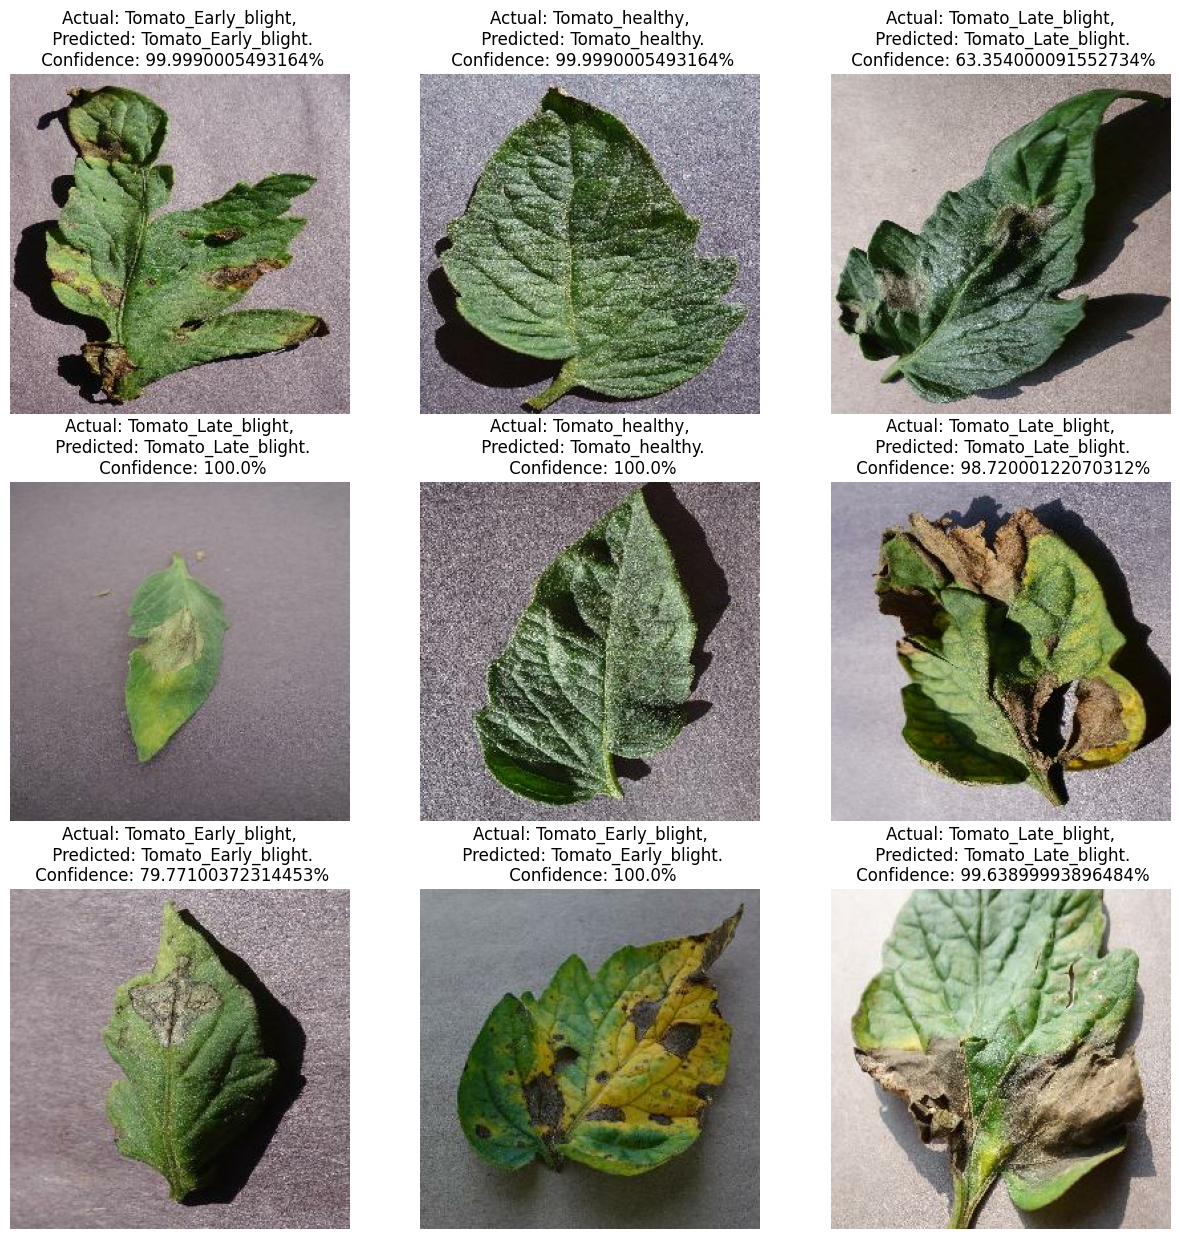

In [73]:
# Making Predications
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, image_batch[i].numpy())
    actual_class = class_names[labels_batch[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")


In [74]:
model.save("Tommato_disease_prediction_cnn.keras")